[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PUBPOL-2130/projects/blob/main/T3/T3.ipynb)

In [1]:
pip install esda libpysal openrouteservice # This is installed to retrieve an ORS API code to make the isochrone map

In [2]:
import requests, zipfile, io
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import openrouteservice
import time
from tqdm import tqdm  # for progress bar

# Show all columns
pd.set_option("display.max_columns", None)
# Show all rows (be careful with large DataFrames!)
pd.set_option("display.max_rows", None)
# Prevent column width truncation
pd.set_option("display.max_colwidth", None)
# Expand DataFrame to fit screen width
pd.set_option("display.expand_frame_repr", False)

In [3]:
# Reset
pd.reset_option("all")

<ipython-input-3-b9d993c1b2cf>:2: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
<ipython-input-3-b9d993c1b2cf>:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


# Transit Externalities (Elliott Serna)

## Import Metadata

This pulls the metadata (i.e., variable names, time coverage, etc.) for the Environment and Health Data Portal data.

In [4]:
# GitHub raw JSON URL
url = "https://raw.githubusercontent.com/nychealth/EHDP-data/production/indicators/metadata/metadata.json"

# Load the JSON
response = requests.get(url)
metadata = response.json()

# Flatten it into a table
records = []
for indicator in metadata:
    for measure in indicator.get("Measures", []):
        records.append({
            "IndicatorID": indicator["IndicatorID"],
            "IndicatorName": indicator["IndicatorName"],
            "IndicatorDescription": indicator["IndicatorDescription"],
            "MeasureID": measure["MeasureID"],
            "MeasureName": measure["MeasureName"],
            "MeasurementType": measure["MeasurementType"],
            "Sources": measure["Sources"],
            "AvailableGeoTypes": measure["AvailableGeoTypes"],
            "AvailableTimePeriodIDs": measure["AvailableTimePeriodIDs"],
        })

eh_indicators = pd.DataFrame(records)


In [5]:
# Load the TimePeriods.json mapping
time_url = "https://raw.githubusercontent.com/nychealth/EHDP-data/production/indicators/metadata/TimePeriods.json"
time_periods = requests.get(time_url).json()
eh_time = pd.DataFrame(time_periods)[["TimePeriodID", "TimePeriod"]]

Now we want to see the different indicators (variables) available to us.

In [6]:
eh_indicators['IndicatorName'].unique()

array(['Preterm birth', 'Very preterm birth', 'Very low birthweight',
       'Low birthweight at full term', 'Death (infants)',
       'Death (neonatal)', 'Death (perinatal)', 'Death (postneonatal)',
       'Foreign-born', 'Household crowding', 'Very old homes',
       'Owner-occupied homes', 'Adults with asthma (past 12 months)',
       'Adults reporting cockroaches',
       'Adults reporting mice or rats outside',
       'Secondhand smoke at home', 'Anencephaly',
       'Spina bifida (without anencephaly)',
       'Hypoplastic left heart syndrome',
       'Transposition of the great arteries (vessels)',
       'Cleft lip (with or without cleft palate)',
       'Cleft palate (without cleft lip)', 'Hypospadias', 'Gastroschisis',
       'Upper limb deficiencies', 'Lower limb Deficiencies',
       'Down Syndrome (Mother under age 35)',
       'Down Syndrome (Mother age 35 and up)',
       'Carbon monoxide incidents', 'Homes with cracks or holes',
       'Old homes with peeling paint', 'H

## Select Indicators of Interest

From this list, we manually select the indicators in the [Active Design](https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/active-design/?id=2389#display=summary) and [Public Transit](https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/walking-driving-and-cycling/?id=2415#display=map) datasets.

In [7]:
# Indicators in Active Design
active_design_indicators = [
    "Neighborhood characteristics",
    "Walking distance to a park",
    "Walkability index",
    "Sidewalk area",
    "Litter basket coverage",
    "Unhealthy food access",
    "Transit coverage",
    "Subway station density",
    "Walking distance to a subway station",
    "Bicycle network coverage",
    "Citi Bike stations",
    "Average Citi Bike availability",
    "Greenery coverage",
    "Tree canopy cover",
    "Vegetative cover"
]

# Indicators in public transit: walking, driving, and cycling
wdc_indicators = [
    "Commuting modes",
    "Walking",
    "Walkability index",
    "Recent walking",
    "Cycling",
    "Walking or biking for transportation",
    "Recent biking",
    "Monthly bicycle use",
    "Average Citi Bike availability",
    "Citi Bike stations",
    "Driving",
    "Recent driving",
    "Recent messaging while driving",
    "Recent speeding",
    "Traffic",
    "Annual vehicle miles traveled",
    "Annual vehicle miles traveled (cars)",
    "Annual vehicle miles traveled (trucks)"
]

# Placeholder list for additional variables of interest
other_eh_indicators = ['Neighborhood poverty', 'Asthma emergency department visits due to PM2.5',]

# Combine indicator lists into analysis variable set
combined_indicators = list(
    set(active_design_indicators) | set(wdc_indicators) | set(other_eh_indicators)
)

eh_indicators_subset = eh_indicators[eh_indicators["IndicatorName"].isin(combined_indicators)]

In [8]:
eh_indicators_subset['MeasureName'].unique() # Displays selected indicators

array(['Poverty, Percent', 'Poverty, Number', 'Poverty, Rank',
       'Walking or biking, Number', 'Walking or biking, Percent',
       'Regular biking, Number', 'Regular biking, Percent',
       'Traffic, Million miles', 'Car traffic, Million miles',
       'Truck traffic, Million miles',
       'PM2.5 asthma ED visits, Estimated annual rate (under age 18)',
       'PM2.5 asthma ED visits, Estimated annual rate (age 18+)',
       'PM2.5 asthma ED visits, Estimated annual number (under age 18)',
       'PM2.5 asthma ED visits, Estimated annual number (age 18+)',
       'Walkability, Score', 'Grass and tree cover, Percent',
       'Tree shade, Percent', 'Subway station density, Density',
       'Walking, Number', 'Walking, Percent', 'Recent biking, Number',
       'Recent biking, Percent', 'Sidewalk area, Percent',
       'Driving, Number', 'Driving, Percent',
       'Texting and driving, Number', 'Texting and driving, Percent',
       'Speeding, Number', 'Speeding, Percent', 'Park acce

## Map Time Periods

Right now, each measure in our data frame has a set of available time periods.

In [9]:
eh_indicators_subset.head()

,IndicatorID,IndicatorName,IndicatorDescription,MeasureID,MeasureName,MeasurementType,Sources,AvailableGeoTypes,AvailableTimePeriodIDs
140,103,Neighborhood poverty,The percent of households with incomes below t...,221,"Poverty, Percent",Percent,American Community Survey,"[Borough, CD, Citywide, NTA2010, Subboro, UHF4...","[203, 235, 236, 242, 247, 255, 257, 287, 288, ..."
141,103,Neighborhood poverty,The percent of households with incomes below t...,233,"Poverty, Number",Number,American Community Survey,"[Borough, CD, Citywide, NTA2010, Subboro, UHF4...","[203, 235, 236, 242, 247, 255, 257, 287, 288, ..."
142,103,Neighborhood poverty,The percent of households with incomes below t...,870,"Poverty, Rank",Rank,American Community Survey,"[CD, NTA2010, Subboro, UHF42]","[203, 235, 236]"
227,2058,Walking or biking for transportation,Adults reporting walking or biking for transpo...,495,"Walking or biking, Number",Number,New York City Community Health Survey (CHS),"[Borough, Citywide, UHF34]",[39]
228,2058,Walking or biking for transportation,Adults reporting walking or biking for transpo...,496,"Walking or biking, Percent",Percent,New York City Community Health Survey (CHS),"[Borough, Citywide, UHF34, UHF42]",[39]


We tidy this by mapping years to the time periods available and 'exploding' the data so each row is one year for every measure.

In [10]:
# Map TimePeriodIDs to TimePeriod labels (i.e. years)
# Explode the TimePeriodIDs
if "AvailableTimePeriodIDs" in eh_indicators_subset.columns:
    eh_indicators_subset = eh_indicators_subset.explode("AvailableTimePeriodIDs")
    eh_indicators_subset = eh_indicators_subset.rename(columns={"AvailableTimePeriodIDs": "TimePeriodID"})

# Ensure both TimePeriodID columns are integers
eh_indicators_subset["TimePeriodID"] = eh_indicators_subset["TimePeriodID"].astype(int)
eh_time["TimePeriodID"] = eh_time["TimePeriodID"].astype(int)

# Merge to get actual time periods (years)
eh_indicators_with_years = eh_indicators_subset.merge(
    eh_time,
    on="TimePeriodID",
    how="left"
)

In [11]:
eh_indicators_with_years.head()

,IndicatorID,IndicatorName,IndicatorDescription,MeasureID,MeasureName,MeasurementType,Sources,AvailableGeoTypes,TimePeriodID,TimePeriod
0,103,Neighborhood poverty,The percent of households with incomes below t...,221,"Poverty, Percent",Percent,American Community Survey,"[Borough, CD, Citywide, NTA2010, Subboro, UHF4...",203,2009-13
1,103,Neighborhood poverty,The percent of households with incomes below t...,221,"Poverty, Percent",Percent,American Community Survey,"[Borough, CD, Citywide, NTA2010, Subboro, UHF4...",235,2010-14
2,103,Neighborhood poverty,The percent of households with incomes below t...,221,"Poverty, Percent",Percent,American Community Survey,"[Borough, CD, Citywide, NTA2010, Subboro, UHF4...",236,2011-15
3,103,Neighborhood poverty,The percent of households with incomes below t...,221,"Poverty, Percent",Percent,American Community Survey,"[Borough, CD, Citywide, NTA2010, Subboro, UHF4...",242,2008-12
4,103,Neighborhood poverty,The percent of households with incomes below t...,221,"Poverty, Percent",Percent,American Community Survey,"[Borough, CD, Citywide, NTA2010, Subboro, UHF4...",247,2012-16


## Overview Indicator Time Coverage

We then review the coverage for every measure.

In [12]:
# Summarize year coverage for each measure
year_coverage = (
    eh_indicators_with_years
    .groupby(["IndicatorName", "MeasureName"])
    .agg(YearsAvailable=("TimePeriod", lambda x: sorted(x.unique())))
    .reset_index()
)
year_coverage

,IndicatorName,MeasureName,YearsAvailable
0,Annual vehicle miles traveled,"Traffic, Million miles","[2005, 2010, 2019]"
1,Annual vehicle miles traveled (cars),"Car traffic, Million miles","[2005, 2010, 2019]"
2,Annual vehicle miles traveled (trucks),"Truck traffic, Million miles","[2005, 2010, 2019]"
3,Asthma emergency department visits due to PM2.5,"PM2.5 asthma ED visits, Estimated annual numbe...","[2005-2007, 2009-2011, 2012-2014, 2015-2017, 2..."
4,Asthma emergency department visits due to PM2.5,"PM2.5 asthma ED visits, Estimated annual numbe...","[2005-2007, 2009-2011, 2012-2014, 2015-2017, 2..."
5,Asthma emergency department visits due to PM2.5,"PM2.5 asthma ED visits, Estimated annual rate ...","[2005-2007, 2009-2011, 2012-2014, 2015-2017, 2..."
6,Asthma emergency department visits due to PM2.5,"PM2.5 asthma ED visits, Estimated annual rate ...","[2005-2007, 2009-2011, 2012-2014, 2015-2017, 2..."
7,Average Citi Bike availability,"Average Citi Bike availability, Bikes per station",[2022]
8,Average Citi Bike availability,"Average Citi Bike availability, Density",[2022]
9,Average Citi Bike availability,"Average Citi Bike availability, Number",[2022]


Seems that data on commuting modes/methods of transportation are more available than, say, tree canopy cover.

## Import Data (For Selected Indicators)

Now that we have our metadata, we download the actual data contents for the indicators we selected above and join it to our metadata.

In [13]:
# Base URL to the indicator data files
base_data_url = "https://raw.githubusercontent.com/nychealth/EHDP-data/production/indicators/data"

# Get unique IndicatorIDs
indicator_ids = eh_indicators_subset["IndicatorID"].unique()

# Container for all data
data_records = []

for indicator_id in tqdm(indicator_ids, desc="Downloading Indicator Data"):
    url = f"{base_data_url}/{indicator_id}.json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data_json = response.json()

        # Convert to DataFrame
        df = pd.DataFrame(data_json)

        # Tag with IndicatorID (for joining later)
        df["IndicatorID"] = indicator_id
        data_records.append(df)

    except Exception as e:
        print(f"Error fetching IndicatorID {indicator_id}: {e}")

# Combine all into one DataFrame
eh_data_all = pd.concat(data_records, ignore_index=True)

# Join metadata (for names and context)
eh_data_all = eh_data_all.merge(
    eh_indicators_subset[["IndicatorID", "MeasureID", "IndicatorName", "MeasureName"]],
    on=["IndicatorID", "MeasureID"],
    how="left"
)

# Map TimePeriodID to Year
eh_data_all = eh_data_all.merge(
    eh_time.rename(columns={"TimePeriodID": "TimePeriodID", "TimePeriod": "Year"}),
    on="TimePeriodID",
    how="left"
)

In [14]:
eh_uhf = eh_data_all[(eh_data_all['GeoType'] == 'UHF42')]

In [15]:
eh_uhf_of_interest = eh_uhf[(eh_data_all['IndicatorName'] == 'Asthma emergency department visits due to PM2.5') |
 (eh_data_all['IndicatorName'] == 'Neighborhood poverty') |
 (eh_data_all['IndicatorName'] == 'Commuting modes')]

<ipython-input-15-fe1955e5c726>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eh_uhf_of_interest = eh_uhf[(eh_data_all['IndicatorName'] == 'Asthma emergency department visits due to PM2.5') |


Lastly, to further tidy the data, we pivot the table into a wider format so that measures are columns. Currently, we are in a long format where all measures are in a single column. For styling, we also clean names.

In [16]:
conditions = (
    ((eh_uhf_of_interest["IndicatorName"] == "Asthma emergency department visits due to PM2.5") &
     (eh_uhf_of_interest["Year"] == "2017-2019")) |

    ((eh_uhf_of_interest["IndicatorName"] == "Neighborhood poverty") &
     (eh_uhf_of_interest["Year"] == "2017-21")) |

    ((eh_uhf_of_interest["IndicatorName"] == "Commuting modes") &
     (eh_uhf_of_interest["Year"] == "2017-21"))
)

eh_analysis = eh_uhf_of_interest[conditions]

eh_pivoted = (
    eh_analysis
    .pivot_table(
        index=["GeoID", "GeoType"],
        columns="MeasureName",
        values="Value",
        aggfunc="mean"  # or "first" if only one value per group
    )
    .reset_index()
)

# Clean column names for clarity
eh_pivoted.columns.name = None  # remove pandas naming on column level

eh_pivoted.columns = (
    eh_pivoted.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

eh_pivoted

,geoid,geotype,"commuting_modes,_bicycle_(number)","commuting_modes,_bicycle_(percent)","commuting_modes,_car,_truck,_or_van_(number)","commuting_modes,_car,_truck,_or_van_(percent)","commuting_modes,_public_transportation_(number)","commuting_modes,_public_transportation_(percent)","commuting_modes,_walked_(number)","commuting_modes,_walked_(percent)","pm2.5_asthma_ed_visits,_estimated_annual_number_(age_18+)","pm2.5_asthma_ed_visits,_estimated_annual_number_(under_age_18)","pm2.5_asthma_ed_visits,_estimated_annual_rate_(age_18+)","pm2.5_asthma_ed_visits,_estimated_annual_rate_(under_age_18)","poverty,_number","poverty,_percent"
0,101,UHF42,117.0,0.2869,13210.0,32.3894,19332.0,47.3998,2955.0,7.2453,13.0,9.0,16.0,48.0,14713.0,16.1624
1,102,UHF42,212.0,0.2327,39660.0,43.5245,40556.0,44.5079,4464.0,4.8990,61.0,37.0,36.0,81.0,30694.0,14.8187
2,103,UHF42,637.0,0.5909,21636.0,20.0701,68029.0,63.1055,9080.0,8.4228,101.0,79.0,49.0,112.0,73579.0,27.7376
3,104,UHF42,577.0,0.4545,48048.0,37.8483,61334.0,48.3139,7450.0,5.8685,83.0,58.0,34.0,80.0,61654.0,20.3036
4,105,UHF42,324.0,0.3945,17885.0,21.7772,52121.0,63.4639,4953.0,6.0309,110.0,74.0,67.0,119.0,73064.0,33.5579
5,106,UHF42,393.0,0.4832,14309.0,17.5944,53415.0,65.6793,8008.0,9.8467,129.0,84.0,78.0,138.0,78111.0,35.7903
6,107,UHF42,329.0,0.6302,10234.0,19.6031,32027.0,61.3474,5346.0,10.2402,88.0,60.0,83.0,147.0,51580.0,36.2596
7,201,UHF42,2618.0,4.3201,7150.0,11.7987,32126.0,53.0132,6705.0,11.0644,12.0,5.0,14.0,21.0,18006.0,17.1015
8,202,UHF42,5039.0,3.4053,13480.0,9.1097,78141.0,52.8072,16636.0,11.2425,50.0,22.0,23.0,43.0,36762.0,13.6731
9,203,UHF42,4300.0,2.6148,24712.0,15.0272,101290.0,61.5939,9851.0,5.9903,149.0,79.0,55.0,107.0,75561.0,21.5549


# Shape Files

Now that we have our analysis data frame, we download the UHF42 shapefiles also provided in the EHDP dataset.

In [17]:

# Download and extract EHDP UHF42 zip
zip_url = "https://github.com/nychealth/EHDP-data/archive/refs/heads/production.zip"
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("uhf42_tmp")  # Creates a folder with all content

# Load the shapefiles
shp_path = "uhf42_tmp/EHDP-data-production/geography/UHF 42/UHF_42_DOHMH.shp"
uhf42_gdf = gpd.read_file(shp_path)


In [18]:
uhf42_gdf.columns

Index(['UHFCODE', 'UHFNAME', 'BOROUGH', 'UHF', 'ALTCHPUHF', 'CHSUHF',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

We merge the geodata to the analysis data.

In [19]:
# Ensure GeoID is the same type as UHFCODE (probably int)
eh_pivoted["geoid"] = eh_pivoted["geoid"].astype(int)

# Merge on UHFCODE
eh_merged = uhf42_gdf.merge(eh_pivoted, left_on="UHFCODE", right_on="geoid")

eh_merged.columns

Index(['UHFCODE', 'UHFNAME', 'BOROUGH', 'UHF', 'ALTCHPUHF', 'CHSUHF',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry', 'geoid', 'geotype',
       'commuting_modes,_bicycle_(number)',
       'commuting_modes,_bicycle_(percent)',
       'commuting_modes,_car,_truck,_or_van_(number)',
       'commuting_modes,_car,_truck,_or_van_(percent)',
       'commuting_modes,_public_transportation_(number)',
       'commuting_modes,_public_transportation_(percent)',
       'commuting_modes,_walked_(number)', 'commuting_modes,_walked_(percent)',
       'pm2.5_asthma_ed_visits,_estimated_annual_number_(age_18+)',
       'pm2.5_asthma_ed_visits,_estimated_annual_number_(under_age_18)',
       'pm2.5_asthma_ed_visits,_estimated_annual_rate_(age_18+)',
       'pm2.5_asthma_ed_visits,_estimated_annual_rate_(under_age_18)',
       'poverty,_number', 'poverty,_percent'],
      dtype='object')

And lastly, we plot three choropleths: one of asthma outcomes, one of poverty, and one of walking prevalence.

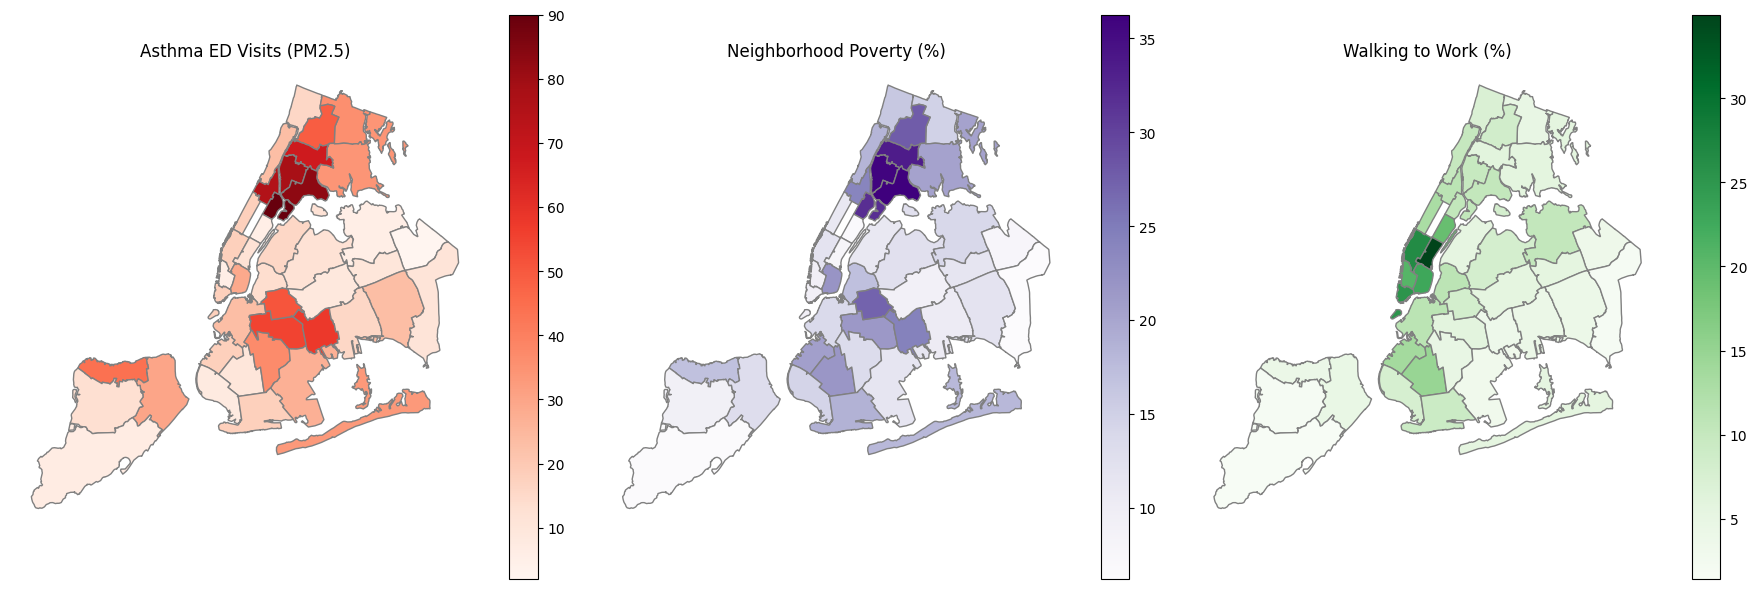

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

eh_merged.plot(column='pm2.5_asthma_ed_visits,_estimated_annual_rate_(age_18+)', cmap='Reds', ax=axes[0], edgecolor='0.5', legend=True)
axes[0].set_title('Asthma ED Visits (PM2.5)')
axes[0].axis('off')

eh_merged.plot(column='poverty,_percent', cmap='Purples', ax=axes[1], edgecolor='0.5', legend=True)
axes[1].set_title('Neighborhood Poverty (%)')
axes[1].axis('off')

eh_merged.plot(column='commuting_modes,_walked_(percent)', cmap='Greens', ax=axes[2], edgecolor='0.5', legend=True)
axes[2].set_title('Walking to Work (%)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

A visual comparison shows a tight association between neighborhood poverty and poorer health outcomes related to air pollution.

What is not so clear is how walking fits into this relationship; there doesn't seem to be a strong pattern in the choropleth.  

To formalize the question, "Are areas with high (or low) asthma rates surrounded by areas with high (or low) walkability?" we calculate bivariate Moran's I to see if there's a pattern, albeit minute.

In [21]:
from libpysal.weights import Queen
from esda.moran import Moran_BV
import numpy as np

# Create spatial weights
w = Queen.from_dataframe(eh_merged)
w.transform = 'r'  # row-standardize weights

# Extract values
asthma = eh_merged["pm2.5_asthma_ed_visits,_estimated_annual_rate_(age_18+)"].values
walking = eh_merged["commuting_modes,_walked_(percent)"].values

# Calculate Bivariate Moran's I
m_bv = Moran_BV(asthma, walking, w)

print("Bivariate Moran's I (Asthma ~ Walking):", m_bv.I)
print("p-value:", m_bv.p_sim)


('WARNING: ', 37, ' is an island (no neighbors)')
Bivariate Moran's I (Asthma ~ Walking): -0.11551114244850923
p-value: 0.169


<ipython-input-21-935cfa5cab77>:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(eh_merged)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 37.
  W.__init__(self, neighbors, ids=ids, **kw)


Though we get a negative value, suggesting high asthma locations may tend to be near low walkability areas, the p-value is high, so we cannot confidently say that asthma and walkability are spatially linked.


# **NYC Hospital Data Cleanup & Mapping (2025)** Arefa Rahman

The code below uses the requests library to send a GET request to a public NYC Open Data API endpoint that provides hospital information in JSON format. It checks that the request was successful and then extracts the JSON data from the response. This data is converted into a dataframe for easier visualizaion and manipulation.

In [22]:
url = "https://data.cityofnewyork.us/resource/q6fj-vxf8.json" # This assigns the API endpoint URL to a variable named url
response = requests.get(url) # This sends an HTTP GET request to the URL and stores the response
response.raise_for_status() # This checks if the request was successful and if it was not then it raises an error
hospitals_df = pd.DataFrame(response.json()) # This converts the JSON response into a dataframe

In [23]:
hospitals_df

,facility_type,borough,facility_name,phone,location_1,cross_streets
0,Child Health Center,Manhattan,La Clinica Del Barrio,212-410-7940,"{'type': 'Point', 'coordinates': [-73.93266794...",NaN
1,Acute Care Hospital,Queens,Elmhurst Hospital Center,718-334-4000,"{'type': 'Point', 'coordinates': [-73.87835115...",NaN
2,Child Health Center,Brooklyn,Ida G. Israel Community Health Center,718-946-3400,"{'type': 'Point', 'coordinates': [-73.98949714...",W. 22nd St. & W. 23rd St.
3,Child Health Center,Queens,South Queens Community Health Center,718-883-6699,"{'type': 'Point', 'coordinates': [-73.77530690...",NaN
4,Child Health Center,Bronx,Melrose Houses Child Health Clinic,718-292-2820,"{'type': 'Point', 'coordinates': [-73.91770978...",between Morris Ave. & Courtlandt Ave.
...,...,...,...,...,...,...
73,Child Health Center,Brooklyn,Bushwick Community Health Center,718-919-1200,"{'type': 'Point', 'coordinates': [-73.90908238...",NaN
74,Child Health Center,Manhattan,Bellevue Hospital Center,212-562-4141,"{'type': 'Point', 'coordinates': [-73.97657284...",NaN
75,Child Health Center,Queens,Ridgewood Communicare Clinic,718-334-6190,"{'type': 'Point', 'coordinates': [-73.90543308...",between Woodbine St. & Madison St.
76,Child Health Center,Manhattan,Smith Communicare Health Center,212-346-0500,"{'type': 'Point', 'coordinates': [-73.99754221...",corner of Catherine St.


The code below cleans the location_1 column by extracting the coordinate values and converting them into separate longitude and latitude columns. This transformation is necessary because the original values are stored as dictionary-like strings in the format {'type': 'Point', 'coordinates': [longitude, latitude]}, which is not directly usable for mapping. I use the .str.replace() function to remove the extra text around the numeric values and then applies .str.split() to separate the coordinates. Finally, I  are convert the values to floats so they can be used easily in mapping visualizations later on.

In [24]:
# This converts the location_1 column to a string and removes the beginning part of the dictionary
remove_naming=(
    hospitals_df['location_1']
    .astype(str)
    .str.replace("{'type': 'Point', 'coordinates': [", '', regex=False) # This removes the opening dictionary text
    .str.replace("]}", '', regex=False) # This removes the closing brackets and brace
)
split_long_lat=remove_naming.str.split(', ', expand=True)   # This splits the cleaned string into longitude and latitude and
# Returns a full DataFrame with each part in its own column
hospitals_df['longitude'] = split_long_lat[0].astype(float) # This assigns the first part as longitude and converts it to float
hospitals_df['latitude'] = split_long_lat[1].astype(float)  # This assigns the second part as latitude and converts it to float
hospitals_df.drop(columns='location_1', inplace=True)       # This removes the location_1 column so there is not redundant long and lat

In [25]:
hospitals_df

,facility_type,borough,facility_name,phone,cross_streets,longitude,latitude
0,Child Health Center,Manhattan,La Clinica Del Barrio,212-410-7940,NaN,-73.932668,40.798205
1,Acute Care Hospital,Queens,Elmhurst Hospital Center,718-334-4000,NaN,-73.878351,40.738710
2,Child Health Center,Brooklyn,Ida G. Israel Community Health Center,718-946-3400,W. 22nd St. & W. 23rd St.,-73.989497,40.578488
3,Child Health Center,Queens,South Queens Community Health Center,718-883-6699,NaN,-73.775307,40.676945
4,Child Health Center,Bronx,Melrose Houses Child Health Clinic,718-292-2820,between Morris Ave. & Courtlandt Ave.,-73.917710,40.821301
...,...,...,...,...,...,...,...
73,Child Health Center,Brooklyn,Bushwick Community Health Center,718-919-1200,NaN,-73.909082,40.684304
74,Child Health Center,Manhattan,Bellevue Hospital Center,212-562-4141,NaN,-73.976573,40.739623
75,Child Health Center,Queens,Ridgewood Communicare Clinic,718-334-6190,between Woodbine St. & Madison St.,-73.905433,40.702950
76,Child Health Center,Manhattan,Smith Communicare Health Center,212-346-0500,corner of Catherine St.,-73.997542,40.711970


# **Hospitals Walkability on Foot Isochrone Map (2025)** Arefa Rahman

> This isochrone map illustrates the walking accessibility of each hospital by showing how far an individual can travel on foot within a given time frame. The blue shapes represent the walkable zones 10 to 30 minutes from each hospital.



The code below generates isochrone maps for hospitals using the OpenRouteService API. I first requested a free API key from openrouteservice.org to request isochrones. After cleaning the location_1 column above, I used a for loop along with the .iterrows() function to iterate through all 78 rows of the hospital dataset. Inside the loop, I used the pd.notna() function to check for valid coordinate values and constructed the hospital’s coordinates in the [longitude, latitude] format required by the API. I then called client.isochrones() to request walking travel zones for 10 and 30 minutes (range=[600, 1800]), and used folium.GeoJson() to visualize the resulting polygons on the map. To avoid exceeding the rate limit of 20 requests per minute, I added a 5 seconds delay between each request using time.sleep(5). The final map, displayed using the map object itself, shows how far a person can walk from each hospital, which helps evaluate public accessibility.

In [26]:
ORS= openrouteservice.Client(key="5b3ce3597851110001cf6248710a52d0cecc42899a9b3abfdddc4034") # This creates the ORS client using my API key
hospitals_isochrone_map=folium.Map(location=[40.7128, -74.0060]) # This sets up a folium map centered around NYC
for index, row in hospitals_df.head(78).iterrows(): # This loops through all the hospitals in the dataset
  if pd.notna(row['longitude']) and pd.notna(row['latitude']): # This checks if the hospital has valid longitude and latitude values
    start_coordinates = [[row['longitude'], row['latitude']]] # This formats the hospital coordinates as [longitude, latitude] for ORS
    isochrone_request= ORS.isochrones( # This sends the isochrone request for 10 to 30 minutes walking range
        locations=start_coordinates,
        profile='foot-walking',
        range=[600,1800],
        interval=600
        )
    folium.GeoJson(isochrone_request, name="hospital isochrone").add_to(hospitals_isochrone_map) # This adds the resulting isochrone polygon to the folium map
    time.sleep(5) # This waits 5 seconds before each requests to avoid hitting the API’s rate limit
hospitals_isochrone_map

# **Transit Mode for Grocery Shopping and Medical Visits in NYC** Antony Jia

This part utilizes the Citywide Mobility Survey (2022) conducted by the New York City Department of Transportation to gain insight into what modes of transportation New Yorkers of different boroughs use to buy groceries and go to medical visits, two activities in the focus of this project
.


In [27]:
import matplotlib.pyplot as plt
import pandas as pd

Data Loading. The CMS surveys data at four levels, the household level, the person level, the day level and trip level. This plot doesn't actually need the person level data, so it's commented out here.

CMS assigned weights to entries at the person level to adjust the proportion of different respondants' answers, to match PUMS data in each of the survey regions. The weights are then prorated down to the day level and the trip level. At the trip level, the "weight" is supposed to represent "the typical number of trips like this residents from this survey region make on a weekday".
Weighting targets include age, gender, ethnicity, income.

However, it isn't very clear from their documentation from which survey region the weights for each "trip" is prorated from (which could have been a seemingly obvious thing for them!) From the data, the only "zone" variable that does not have "11-Outside Survey Region" as a valid response is "hh_cms_zone" in the household table, and that is what I'll be using. Yet I was able to recreate one of the plots in their official report by using the "destination survey zone" for trips, showing that the weights commensurate across zones and do not have a zone-specific "unit".

**Note**: For this, you will have to add the data into the local/runtime colab file directory.

In [28]:
!curl -L -o CMST.zip https://github.com/PUBPOL-2130/projects/raw/main/T3/CMST.zip
!unzip -o CMST.zip -d trip_data

!curl -L -o CMSH.zip https://github.com/PUBPOL-2130/projects/raw/main/T3/CMSH.zip
!unzip -o CMSH.zip -d household_data

Trip_df = pd.read_csv("trip_data/CMST.csv")
Household_df = pd.read_csv("household_data/CMSH.csv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3708k  100 3708k    0     0  3601k      0  0:00:01  0:00:01 --:--:-- 3601k
Archive:  CMST.zip
  inflating: trip_data/CMST.csv      
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 82932  100 82932    0     0   178k      0 --:--:-- --:--:-- --:--:--  178k
Archive:  CMSH.zip
  inflating: household_data/CMSH.csv  


In [29]:
# Define codebook translations
region_dict = {
    1: "Northern Bronx",
    2: "Southern Bronx",
    3: "Northern Manhattan",
    4: "Manhattan Core",
    5: "Inner Queens",
    6: "Middle Queens",
    7: "Outer Queens",
    8: "Inner Brooklyn",
    9: "Outer Brooklyn",
    10: "Staten Island",
    11: "Outside study region"
}

regions = [
    "Northern Bronx",
    "Southern Bronx",
    "Northern Manhattan",
    "Manhattan Core",
    "Inner Queens",
    "Middle Queens",
    "Outer Queens",
    "Inner Brooklyn",
    "Outer Brooklyn",
    "Staten Island",
    # "Outside study region"
]

r_modes = [
    "Vehicle",
    "Bus",
    "Rail",
    "Walk",
    "Bike",
    "Other"
]


In [30]:
# Filter for trips related to medical visits and grocery shopping
Medical_df = Trip_df[Trip_df['d_purpose'].isin([30,32,34])]

# Detect the region where the respondant lives
Medical_df2 = pd.merge(Medical_df, Household_df[['hh_id','hh_cms_zone_gp']],on='hh_id',how='left')
Medical_df

,hh_id,person_id,person_num,day_id,travel_dow,day_num,is_complete,travel_date,linked_trip_id,linked_leg_num,...,dwell_mins,high_speed_flag,long_distance_flag,o_cms_zone,d_cms_zone,unlinked_trip,o_location_type,d_location_type,trip_wkday_weight,trip_svnday_weight
2,22000050,2200005001,1,220000500106,2,6,1,10/18/2022,2200005001003,1,...,14.716667,0,0,2,3,0,1,4,359.540113,215.724068
27,22000105,2200010501,1,220001050103,3,3,1,10/19/2022,2200010501021,3,...,0.000000,0,0,2,2,0,4,4,861.630290,492.360166
28,22000105,2200010501,1,220001050103,3,3,1,10/19/2022,2200010501024,1,...,90.000000,0,0,2,2,0,4,4,861.630290,492.360166
58,22000105,2200010501,1,220001050106,6,6,1,10/22/2022,2200010501052,1,...,8.983333,1,0,3,4,0,4,4,0.000000,492.360166
59,22000105,2200010501,1,220001050106,6,6,1,10/22/2022,2200010501053,1,...,55.483333,0,0,3,3,0,4,4,0.000000,492.360166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86315,22145725,2214572501,1,221457250102,3,2,1,10/19/2022,2214572501001,3,...,112.950000,0,0,10,10,1,4,4,504.915312,288.523035
86328,22145725,2214572501,1,221457250107,1,7,995,10/24/2022,2214572501013,3,...,51.566667,0,0,10,10,1,4,4,0.000000,0.000000
86335,22145726,2214572601,1,221457260101,2,1,1,10/25/2022,2214572601001,1,...,35.000000,0,0,5,5,0,995,995,153.303195,153.303195
86336,22145726,2214572601,1,221457260101,2,1,1,10/25/2022,2214572601002,1,...,19.000000,0,0,5,5,0,995,995,153.303195,153.303195


In [31]:
import numpy as np

# Define containers to hold the weighted data
type_dict = {}
distance_dict = {}
duration_dict = {}

# Iterate over all survey zones
for i in range(1,11):
  weights_sum = 1
  distance_sum = 0
  duration_sum = 0

  # A zero vector to hold weighted counts for the six transit modes
  transit_type_sum = np.zeros(6)

  # Iterate over all trips made by residents of survey zone i
  for index, row in (Medical_df2[Medical_df2['hh_cms_zone_gp']==i]).dropna(subset=['distance_miles']).iterrows():
  # For index, row in (Medical_df2[Medical_df2['d_cms_zone']==i]).dropna(subset=['distance_miles']).iterrows():
    weight = row['trip_wkday_weight']
    # Weight = 1

    # For people who responded to the transit mode question
    if row['r_mode_type_nyc'] != 995:

      # Maintaining a weighted sum for the three variables
      weights_sum += weight
      distance_sum += row['distance_miles']*weight
      duration_sum += row['duration_minutes']*weight
      t_type = row['r_mode_type_nyc']
      transit_type_sum[t_type-1] += weight

  # Normalizing over weight sums in the region
  type_dict[region_dict[i]] = transit_type_sum/weights_sum
  duration_dict[region_dict[i]] = duration_sum/weights_sum
  distance_dict[region_dict[i]] = distance_sum/weights_sum
  print('%s:%s,%s, %s' %(region_dict[i], distance_sum/weights_sum, duration_sum/weights_sum, 100*transit_type_sum/weights_sum))


Northern Bronx:1.774555572649043,15.348402562923676, [45.6870299   0.          0.         52.89127426  0.          1.42120358]
Southern Bronx:3.0477577059381926,49.254344440832675, [61.79513815  0.          0.         38.07187901  0.          0.13257997]
Northern Manhattan:1.564958182354441,19.682676489206372, [16.80522095  0.          0.         72.21545039 10.85263667  0.12644176]
Manhattan Core:1.7282654115562457,16.581942213102906, [44.01084989  0.27362409  0.         53.07957833  2.63572884  0.        ]
Inner Queens:1.5147015946879467,12.967690093787434, [2.62817233e+01 1.41495084e-02 0.00000000e+00 6.06941541e+01
 1.29408991e+01 6.87048196e-02]
Middle Queens:2.179847717344493,15.427927803275738, [17.43746875  0.          0.         79.13443089  2.29747014  1.12982188]
Outer Queens:2.701364236643272,17.940088233136382, [81.74810822  0.          0.         18.10598599  0.          0.14562905]
Inner Brooklyn:3.6782352225685377,19.284620595640995, [8.95330205e+01 0.00000000e+00 0.000

Text(0.5, 1.0, 'Mode of Transit for Wellbeing-Related Trips By Household Region')

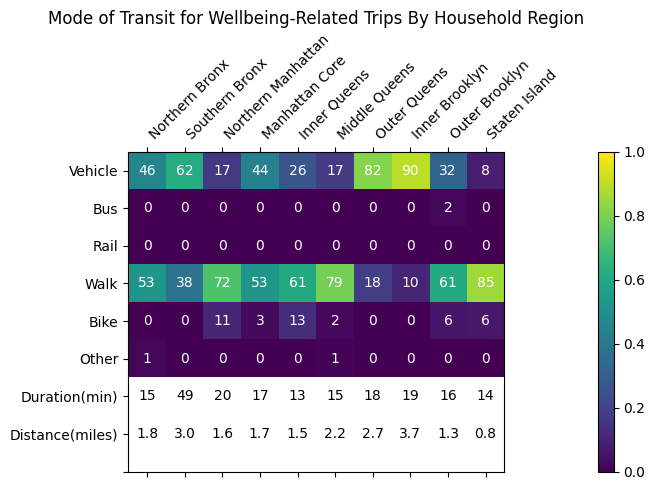

In [32]:
region_list = []
for region, weighted in type_dict.items():
  region_list.append(weighted)

imat = np.array(region_list)

fig, ax = plt.subplots(1,1,layout='tight',figsize=(19, 5))

# Create heatmap
cax = ax.matshow(imat.T, cmap='viridis', vmin=0, vmax=1)
corr = imat.T

# Add colorbar
fig.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(8.5))
ax.set_xticklabels(regions, rotation=45, ha="left")

# Modes plus appended labels for duration and distance
ax.set_yticklabels(r_modes+['Duration(min)','Distance(miles)',' '])

# Annotate with percentage values, minutes and miles
for i in range(10):
    for j in range(6):
        # Annotate with percentage for transit mode in each region for each mode
        ax.text(i, j, f"{100*corr[j][i]:.0f}", ha='center', va='center', color='white')

    # Annotate the 6th and 7th row with weighted average durations and distance in minutes and miles
    ax.text(i, 6, f"{duration_dict[region_dict[i+1]]:.0f}", ha='center', va='center', color='black')
    ax.text(i, 7, f"{distance_dict[region_dict[i+1]]:.1f}", ha='center', va='center', color='black')

# Title
ax.set_title("Mode of Transit for Wellbeing-Related Trips By Household Region")



Caveats:

This plot makes me very doubtful of the weighting process of the CMS. In this plot, almost no one goes on medical visits or grocery shopping by bus or rail, which is surprising.

Upon inspecting the data, I find there are many entries of these activities reported with rail or bus as mode of transit, but their weight was set to 0 for some reason. Also, almost all trips on public transit with non-zero weight were identified with purpose "1", or "going home", and the significant public transit usage given in their official report are mainly derived from those entries. Maybe they found respondants specifying exact trip purposes like "Grocery Shopping" among 50 choices to be too sporadic for sound inference, and did not weight these trips to facilitate specific research on these categories.

## **Health Quality Cross-Comparison by Borough in Adults (2019-2022)** Camille Brady

The section of code reads in borough-level public health data for New York City and creates three bar plots to visualize relationships between health outcomes, disease prevalence, and health-related behaviors. I pulled my data manually from the NYC Data Community Health Profiles, as well as the New York State Department of Health. The first graph displays key chronic disease indicators — *obesity, asthma, diabetes, and hypertension* — by borough for 2022. The second graph presents citywide cardiovascular disease rates, specifically heart attack and stroke prevalence. The third graph shows behavioral metrics such as physical activity, fresh produce consumption, and sugary drink intake across boroughs from 2019 to 2020. I created these plots using grouped and color-coded bars with labeled values for clarity. The visualizations are designed to make inter-borough comparisons straightforward and to support analysis of how health disparities may align with differences in transit access, walkability, and built environment conditions.

In [33]:
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

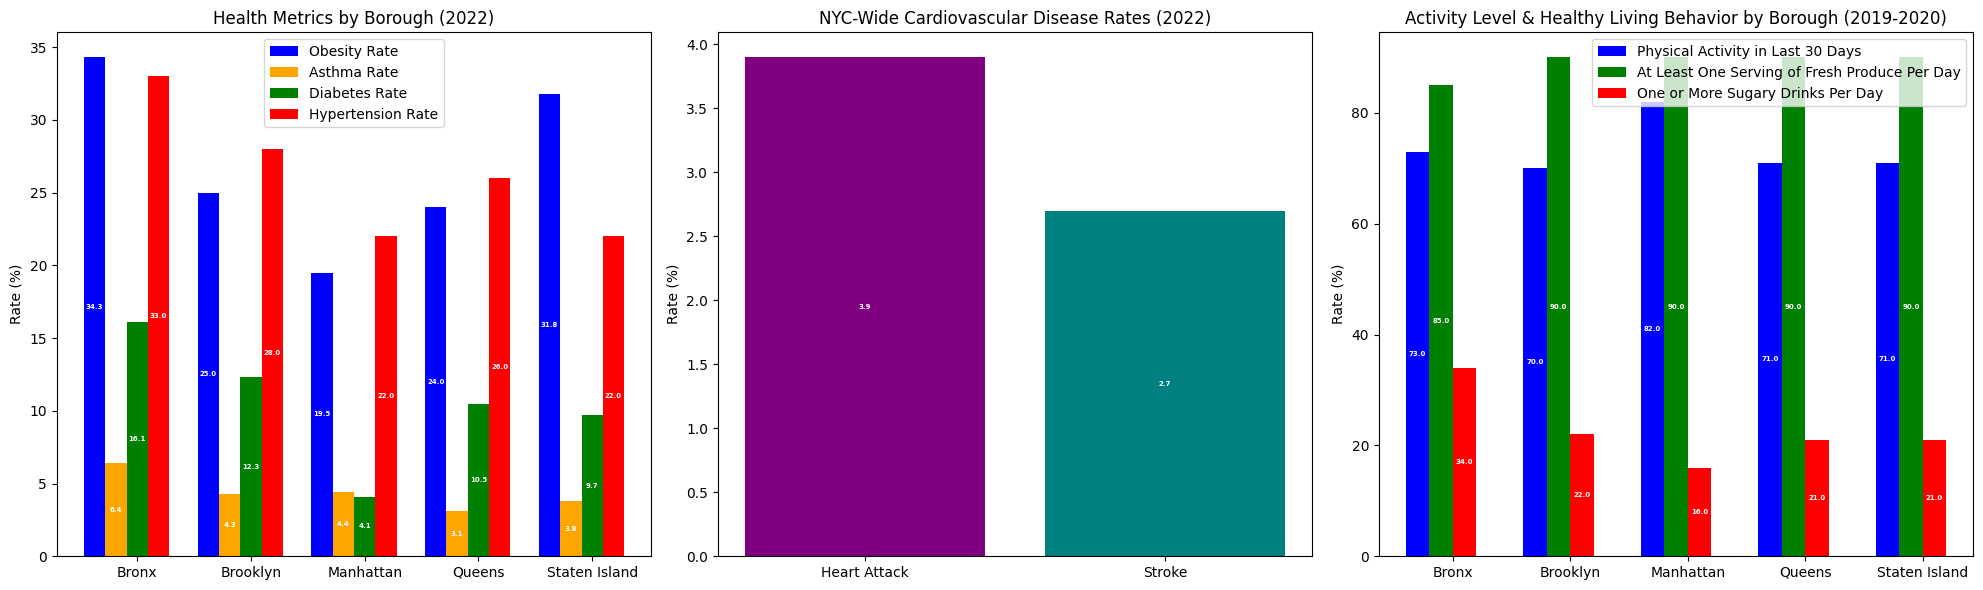

In [34]:
# Standardize plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Add percentage labels to each bar
def add_bar_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height / 2,  # Centered vertically
            f'{height:.1f}',
            ha='center',
            va='center',
            color='white',
            fontsize=5,
            fontweight='bold'
        )

# ---- Graph 1: Borough-level health data ----

boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

# Import data
obesity_rates = [34.3, 25, 19.5, 24, 31.8]
asthma_rates = [6.4, 4.3, 4.4, 3.1, 3.8]
diabetes_rates = [16.1, 12.3, 4.1, 10.5, 9.7]
hypertension_rates = [33, 28, 22, 26, 22]

# Establish Graph 1 settings
num_metrics = 4
bar_width = 0.15
group_gap = 0.2  # Gap between boroughs

# Create positions for each bar in Graph 1
x = []
labels = []
tick_positions = []

for i in range(len(boroughs)):
    start = i * (num_metrics * bar_width + group_gap)
    for j in range(num_metrics):
        x.append(start + j * bar_width)
    tick_positions.append(start + (num_metrics * bar_width) / 2)
    labels.append(boroughs[i])

# Flatten all rates
all_rates = []
metric_colors = []
for i in range(len(boroughs)):
    all_rates.extend([
        obesity_rates[i],
        asthma_rates[i],
        diabetes_rates[i],
        hypertension_rates[i]
    ])
    metric_colors.extend(['blue', 'orange', 'green', 'red'])

# Plot Graph 1
ax1.bar(x, all_rates, width=bar_width, color=metric_colors)

# Add vertical tick labels only for borough midpoints
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Rate (%)')
ax1.set_title('Health Metrics by Borough (2022)')

# Custom legend for Graph 1
from matplotlib.patches import Patch
metric_labels = ['Obesity Rate', 'Asthma Rate', 'Diabetes Rate', 'Hypertension Rate']
legend_colors = ['blue', 'orange', 'green', 'red']
legend_elements = [Patch(facecolor=legend_colors[i], label=metric_labels[i]) for i in range(len(metric_labels))]
ax1.legend(handles=legend_elements)
bars1 = ax1.bar(x, all_rates, width=bar_width, color=metric_colors)
add_bar_labels(ax1, bars1)

# ---- Graph 2: NYC-wide data ----

# Import NYC-wide data
health_conditions = ['Heart Attack', 'Stroke']
heart_attack_rate = 3.9
stroke_rate = 2.7

# Plot Graph 2
ax2.bar(health_conditions, [heart_attack_rate, stroke_rate], color=['purple', 'teal'])
ax2.set_title('NYC-Wide Cardiovascular Disease Rates (2022)')
ax2.set_ylabel('Rate (%)')

bars2 = ax2.bar(health_conditions, [heart_attack_rate, stroke_rate], color=['purple', 'teal'])
add_bar_labels(ax2, bars2)

# ---- Graph 3: Borough-level physical activity data ----

# Import data
boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
activity_rates = [73, 70, 82, 71, 71]
produce_access = [85, 90, 90, 90, 90]
sugar_drink =    [34, 22, 16, 21, 21]

# Establish Graph 3 settings
num_metrics = 3
bar_width = 0.15
group_gap = 0.3  # Gap between boroughs

# Create positions for each bar in Graph 3
x = []
labels = []
tick_positions = []

for i in range(len(boroughs)):
    start = i * (num_metrics * bar_width + group_gap)
    for j in range(num_metrics):
        x.append(start + j * bar_width)
    tick_positions.append(start + (num_metrics * bar_width) / 2)
    labels.append(boroughs[i])

# Flatten all rates
all_rates = []
metric_colors = []
for i in range(len(boroughs)):
    all_rates.extend([
        activity_rates[i],
        produce_access[i],
        sugar_drink[i]
    ])
    metric_colors.extend(['blue', 'green', 'red'])

# Plot Graph 3
ax3.bar(x, all_rates, width=bar_width, color=metric_colors)

# Add vertical tick labels only for borough midpoints
ax3.set_xticks(tick_positions)
ax3.set_xticklabels(labels)
ax3.set_ylabel('Rate (%)')
ax3.set_title('Activity Level & Healthy Living Behavior by Borough (2019-2020)')

# Custom legend for Graph 3
metric_labels = [
    'Physical Activity in Last 30 Days',
    'At Least One Serving of Fresh Produce Per Day',
    'One or More Sugary Drinks Per Day'
]
legend_colors = ['blue', 'green', 'red']
legend_elements = [Patch(facecolor=legend_colors[i], label=metric_labels[i]) for i in range(len(metric_labels))]
ax3.legend(handles=legend_elements)
bars3 = ax3.bar(x, all_rates, width=bar_width, color=metric_colors)
add_bar_labels(ax3, bars3)

# Save figure
from google.colab import files
plt.savefig('nyc_graphs.png')
files.download('nyc_graphs.png')

# Review layout
plt.tight_layout()
plt.show()


## **Deli/Convience Store Proximity** Fatou Diaw

The New York State Department of Agriculture and Markets' Retail Food Stores dataset is a comprehensive dataset that catalogs all licensed retail food establishments in New York State, including information on store type, location coordinates, license status, and operational details. I want to visualize    the distribution of distances between deli food stores across New York City's five boroughs (Bronx, Kings/Brooklyn, New York/Manhattan, Queens, and Richmond/Staten Island). This measurement serves as a critical indicator of food accessibility

First request the NYC Open Data API that gives retail information in json format. Then extract the JSON data, convert to dataframe.

In [35]:
url = "https://data.ny.gov/resource/9a8c-vfzj.json?$limit=2000"
response = requests.get(url)
response.raise_for_status()
deli_df = pd.DataFrame(response.json())
deli_df

,county,license_number,operation_type,estab_type,entity_name,dba_name,street_number,street_name,city,state,zip_code,georeference,:@computed_region_yamh_8v7k,address_line_2,square_footage
0,SUFFOLK,763163,Store,A,HEALTHY MEALS DIRECT LLC,HEALTHY MEALS DIRECT,1866,DEER PARK AVE,DEER PARK,NY,11729,"{'type': 'Point', 'coordinates': [-73.32901606...",1023,NaN,NaN
1,TIOGA,763162,Store,A,ALDI INC,ALDI #62,1150,STATE ROUTE 17C,OWEGO,NY,13827,"{'type': 'Point', 'coordinates': [-76.23185940...",53,NaN,NaN
2,WESTCHESTER,763161,Store,A,WALGREEN EASTERN CO INC,WALGREENS #21443,3320,CROMPOND RD,YORKTOWN HEIGHTS,NY,10598,"{'type': 'Point', 'coordinates': [-73.83005186...",947,NaN,NaN
3,SUFFOLK,763134,Store,A,SANJHA BAZAAR LLC,SANJHA BAZAAR,2160,JERICHO TURNPIKE,COMMACK,NY,11725,"{'type': 'Point', 'coordinates': [-73.28455249...",1014,NaN,NaN
4,KINGS,763133,Store,A,SKILLMART INC,SKILLMART,1010,BEDFORD AVE,BROOKLYN,NY,11205,"{'type': 'Point', 'coordinates': [-73.95548679...",894,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,BRONX,756788,Store,AC,FERRERA DELI GROCERY CORP,FERRERA DELI GROCERY,2381,VALENTINE AVE,BRONX,NY,10458,"{'type': 'Point', 'coordinates': [-73.89741898...",307,NaN,NaN
1996,ORANGE,756786,Store,AC,MANCILLA ELIZONDO LUIS FELIPE,VIVA MEXICAN GROCERY,32,SMITH CLOVE RD,CENTRAL VALLEY,NY,10917,"{'type': 'Point', 'coordinates': [-74.11902082...",883,NaN,1200
1997,ONONDAGA,756783,Store,AC,KINNE STREET MINI MART LLC,MINI MART,246,KINNE ST,EAST SYRACUSE,NY,13057,"{'type': 'Point', 'coordinates': [-76.07676200...",702,NaN,500
1998,SUFFOLK,756782,Store,AC,EWA DELI INC,EWA DELI,1635,GREAT NECK RD,COPIAGUE,NY,11726,"{'type': 'Point', 'coordinates': [-73.39952680...",1023,NaN,860


In [36]:
# Fix location data
import ast

deli_df['georeference'] = deli_df['georeference'].astype(str)
deli_df['georeference'] = deli_df['georeference'].apply(ast.literal_eval)

# Extract longitude and latitude from the 'coordinates' key
deli_df['longitude'] = deli_df['georeference'].apply(lambda x: x['coordinates'][0])
deli_df['latitude'] = deli_df['georeference'].apply(lambda x: x['coordinates'][1])
deli_df

,county,license_number,operation_type,estab_type,entity_name,dba_name,street_number,street_name,city,state,zip_code,georeference,:@computed_region_yamh_8v7k,address_line_2,square_footage,longitude,latitude
0,SUFFOLK,763163,Store,A,HEALTHY MEALS DIRECT LLC,HEALTHY MEALS DIRECT,1866,DEER PARK AVE,DEER PARK,NY,11729,"{'type': 'Point', 'coordinates': [-73.32901606...",1023,NaN,NaN,-73.329016,40.759931
1,TIOGA,763162,Store,A,ALDI INC,ALDI #62,1150,STATE ROUTE 17C,OWEGO,NY,13827,"{'type': 'Point', 'coordinates': [-76.23185940...",53,NaN,NaN,-76.231859,42.096558
2,WESTCHESTER,763161,Store,A,WALGREEN EASTERN CO INC,WALGREENS #21443,3320,CROMPOND RD,YORKTOWN HEIGHTS,NY,10598,"{'type': 'Point', 'coordinates': [-73.83005186...",947,NaN,NaN,-73.830052,41.291525
3,SUFFOLK,763134,Store,A,SANJHA BAZAAR LLC,SANJHA BAZAAR,2160,JERICHO TURNPIKE,COMMACK,NY,11725,"{'type': 'Point', 'coordinates': [-73.28455249...",1014,NaN,NaN,-73.284552,40.842579
4,KINGS,763133,Store,A,SKILLMART INC,SKILLMART,1010,BEDFORD AVE,BROOKLYN,NY,11205,"{'type': 'Point', 'coordinates': [-73.95548679...",894,NaN,NaN,-73.955487,40.690346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,BRONX,756788,Store,AC,FERRERA DELI GROCERY CORP,FERRERA DELI GROCERY,2381,VALENTINE AVE,BRONX,NY,10458,"{'type': 'Point', 'coordinates': [-73.89741898...",307,NaN,NaN,-73.897419,40.859042
1996,ORANGE,756786,Store,AC,MANCILLA ELIZONDO LUIS FELIPE,VIVA MEXICAN GROCERY,32,SMITH CLOVE RD,CENTRAL VALLEY,NY,10917,"{'type': 'Point', 'coordinates': [-74.11902082...",883,NaN,1200,-74.119021,41.333270
1997,ONONDAGA,756783,Store,AC,KINNE STREET MINI MART LLC,MINI MART,246,KINNE ST,EAST SYRACUSE,NY,13057,"{'type': 'Point', 'coordinates': [-76.07676200...",702,NaN,500,-76.076762,43.070091
1998,SUFFOLK,756782,Store,AC,EWA DELI INC,EWA DELI,1635,GREAT NECK RD,COPIAGUE,NY,11726,"{'type': 'Point', 'coordinates': [-73.39952680...",1023,NaN,860,-73.399527,40.679044


In [37]:
# Convert to GeoDataframe

from shapely.geometry import Point
import geopandas as gpd

deli_df['geometry'] = deli_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
deli_gdf = gpd.GeoDataFrame(deli_df, geometry='geometry', crs='EPSG:4326')
deli_gdf = deli_gdf.to_crs(epsg=3857)

# Filter by establishments codes & types
# B = bakery, C = food manufacturer, D = food warehouse

# Filter by establishment type -- get delis
deli_gdf = deli_gdf[
    deli_gdf['estab_type'].fillna('').str.contains('B') |
    deli_gdf['estab_type'].str.contains('C') |
    deli_gdf['estab_type'].str.contains('D') ]


# Filter for boroughs
bronx_gdf = deli_gdf[deli_gdf['county']== 'BRONX']
manhattan_gdf = deli_gdf[deli_gdf['county'] == 'NEW YORK']
queens_gdf = deli_gdf[deli_gdf['county'] == 'QUEENS']
brooklyn_gdf = deli_gdf[deli_gdf['county'] == 'KINGS']
staten_island_gdf = deli_gdf[deli_gdf['county'] == 'RICHMOND']


In [38]:
# Open shapefiles
boros = gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
boros = boros.to_crs(epsg=3857)
bronx_shape = boros[boros["BoroName"] == "Bronx"]
manhattan_shape = boros[boros["BoroName"] == "Manhattan"]
queens_shape = boros[boros["BoroName"] == "Queens"]
brooklyn_shape = boros[boros["BoroName"] == "Brooklyn"]
staten_island_shape = boros[boros["BoroName"] == "Staten Island"]


Distance Statistics by County:
            count      mean       std       min       25%       50%       75%  \
county                                                                          
BRONX     13695.0  2.518320  1.367781  0.007648  1.495674  2.324448  3.388854   
KINGS     38781.0  3.977606  2.255063  0.000000  2.181084  3.642083  5.537937   
NEW YORK  13695.0  4.014147  2.694499  0.000000  1.679130  3.628624  5.821976   
QUEENS    17391.0  4.996729  2.736813  0.007779  2.973546  4.718272  6.649213   
RICHMOND   1485.0  4.041297  2.751113  0.013829  1.921239  3.615176  5.336975   

                max  
county               
BRONX      7.759226  
KINGS     11.397371  
NEW YORK  13.470319  
QUEENS    14.993144  
RICHMOND  12.623893  


<ipython-input-39-1bcf8bb0ef5a>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(distance_df, x="county", y='distance_miles',order=['BRONX', 'KINGS', 'NEW YORK', 'QUEENS', 'RICHMOND'],


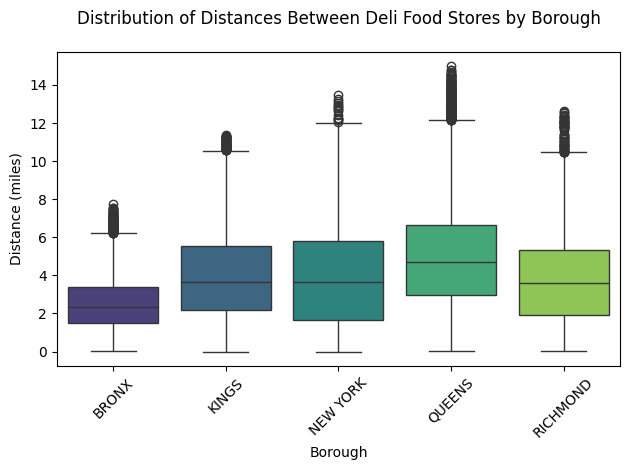

In [39]:

# Distance between deli's
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns

# Empty dict for distances from each county
county_distances = {}

# Convert back to 4326 for coordinates and have all NYC counties in one df
deli_gdf = deli_gdf.to_crs(epsg=4326)
deli_gdf_nyc= deli_gdf[deli_gdf['county'].isin(['BRONX', 'KINGS', 'NEW YORK', 'QUEENS', 'RICHMOND'])]

# Group by county
#for each county reset the index, loop over all unique pairs of delis, get distance in miles, then save to list and add to county_distances
for county_name, group in deli_gdf_nyc.groupby("county"):
    group = group.reset_index(drop=True)
    n = len(group)
    distances = []

    for i in range(n):
        point1 = group.geometry[i]
        for j in range(i + 1, n):
            point2 = group.geometry[j]
            # Compute distance in miles
            dist = distance.distance((point1.y, point1.x), (point2.y, point2.x)).miles

            distances.append(dist)

    county_distances[county_name] = distances

# Convert to a longer df where each row is a distance measurement and in its corresponding county
distance_df = pd.DataFrame([
    {"county": county, "distance_miles": dist}
    for county, dists in county_distances.items()
    for dist in dists
])

# Calculate basic statistics
distance_stats = distance_df.groupby('county')['distance_miles'].describe()
print("Distance Statistics by County:")
print(distance_stats)

# Plot boxplot of distances per county
sns.boxplot(distance_df, x="county", y='distance_miles',order=['BRONX', 'KINGS', 'NEW YORK', 'QUEENS', 'RICHMOND'],
    palette='viridis'
)
plt.title('Distribution of Distances Between Deli Food Stores by Borough', pad=20)
plt.xlabel('Borough')
plt.ylabel('Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distance_boxplot.png')
plt.show()